In [71]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import reuters

### 1. 데이터 준비

In [2]:
# 데이터 불러오기 - 워드 갯수별 딕셔너리에 담기
x_train_set = {}
x_test_set = {}

(x_train_set['025'], y_train), (x_test_set['025'], y_test) = reuters.load_data(num_words=2500, test_split=0.2)
(x_train_set['050'], y_train), (x_test_set['050'], y_test) = reuters.load_data(num_words=5000, test_split=0.2)
(x_train_set['100'], y_train), (x_test_set['100'], y_test) = reuters.load_data(num_words=10000, test_split=0.2)
(x_train_set['200'], y_train), (x_test_set['200'], y_test) = reuters.load_data(num_words=20000, test_split=0.2)
(x_train_set['all'], y_train), (x_test_set['all'], y_test) = reuters.load_data(num_words=None, test_split=0.2)

print(f"  훈련 샘플의 수: {len(x_train_set['025']):6d}, {len(x_train_set['050']):6d}, {len(x_train_set['100']):6d}, {len(x_train_set['200']):6d}, {len(x_train_set['all']):6d}")
print(f"테스트 샘플의 수: {len(x_test_set['025']):6d}, {len(x_test_set['050']):6d}, {len(x_test_set['100']):6d}, {len(x_test_set['200']):6d}, {len(x_test_set['all']):6d}")

2121728/2110848 [==============================] - 0s 0us/step
  훈련 샘플의 수:   8982,   8982,   8982,   8982,   8982
테스트 샘플의 수:   2246,   2246,   2246,   2246,   2246


In [3]:
# 가장 짧은 데이터 찾기
min_length = 10000
min_index = 0

for index, s in enumerate(x_train_set['025']):
    if len(s) < min_length:
        min_length = len(s)
        min_index = index

print(min_index)

6519


In [4]:
# 데이터 확인
print("num_words  2500:", x_train_set['025'][min_index])
print("num_words  5000:", x_train_set['050'][min_index])
print("num_words 10000:", x_train_set['100'][min_index])
print("num_words 20000:", x_train_set['200'][min_index])
print("num_words  None:", x_train_set['all'][min_index])

num_words  2500: [1, 486, 341, 151, 26, 219, 93, 124, 146, 93, 155, 17, 12]
num_words  5000: [1, 486, 341, 151, 26, 219, 93, 124, 146, 93, 155, 17, 12]
num_words 10000: [1, 486, 341, 151, 26, 219, 93, 124, 146, 93, 155, 17, 12]
num_words 20000: [1, 486, 341, 151, 26, 219, 93, 124, 146, 93, 155, 17, 12]
num_words  None: [1, 486, 341, 151, 26, 219, 93, 124, 146, 93, 155, 17, 12]


훈련용 뉴스의 최대 길이: 2376
훈련용 뉴스의 평균 길이: 145.54


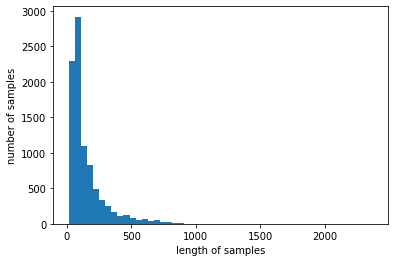

In [6]:
# 데이터의 길이 분포
print(f"훈련용 뉴스의 최대 길이: {max(len(l) for l in x_train_set['025'])}")
print(f"훈련용 뉴스의 평균 길이: {sum(map(len, x_train_set['025']))/len(x_train_set['025']):.2f}")

plt.hist([len(s) for s in x_train_set['025']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

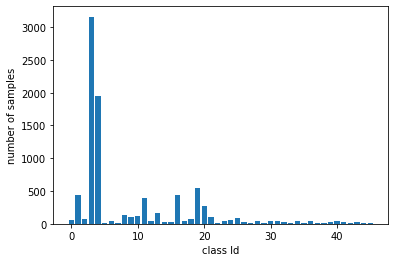

In [7]:
# 클래스 빈도수
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
#print("각 클래스 빈도수:")
#print(np.asarray((unique_elements, counts_elements)))

plt.bar(unique_elements, counts_elements)
plt.xlabel('class Id')
plt.ylabel('number of samples')
plt.show()

In [8]:
# 단어 사전
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

print(f'단어 사전의 크기: {len(word_index)}')

565248/550378 [==============================] - 0s 0us/step
단어 사전의 크기: 30979


In [9]:
# 디코딩 함수
def decode(data):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

In [10]:
# 데이터 셋 디코딩
dataset_index = ['025', '050', '100', '200', 'all']
words_size = {'025': 2500, '050': 5000, '100': 10000, '200': 20000, 'all': 30979}
decoded_x_train_set = {}
decoded_x_test_set = {}

for index in dataset_index:
    decoded_x_train_set[index] = decode(x_train_set[index])

for index in dataset_index:
    decoded_x_test_set[index] = decode(x_test_set[index])

In [12]:
# 데이터 셋 확인
for index in dataset_index:
    print(f"word size: {words_size[index]}")
    print(decoded_x_train_set[index][min_index])

word size: 2500
<sos> qtly div nine cts pay april 30 record april six reuter 3
word size: 5000
<sos> qtly div nine cts pay april 30 record april six reuter 3
word size: 10000
<sos> qtly div nine cts pay april 30 record april six reuter 3
word size: 20000
<sos> qtly div nine cts pay april 30 record april six reuter 3
word size: 30979
<sos> qtly div nine cts pay april 30 record april six reuter 3


### 2. DTM, TF-IDF

In [14]:
# DTM/TF-IDF 관련 라이브러리
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [15]:
# DTN 계산
dtmvector = CountVectorizer()
dtm_x_train_set = {}
dtm_x_test_set = {}
for index in dataset_index:
    dtm_x_train_set[index] = dtmvector.fit_transform(decoded_x_train_set[index])
    dtm_x_test_set[index] = dtmvector.transform(decoded_x_test_set[index])
    print(f'{dtm_x_train_set[index].shape} {dtm_x_test_set[index].shape}')

(8982, 2430) (2246, 2430)
(8982, 4867) (2246, 4867)
(8982, 9670) (2246, 9670)
(8982, 18479) (2246, 18479)
(8982, 26506) (2246, 26506)


In [17]:
# TF-IDF 계산
tfidf_transformer = TfidfTransformer()
tfidf_x_train_set = {}
tfidf_x_test_set = {}
for index in dataset_index:
    tfidf_x_train_set[index] = tfidf_transformer.fit_transform(dtm_x_train_set[index])
    tfidf_x_test_set[index] = tfidf_transformer.transform(dtm_x_test_set[index])
    print(f'{tfidf_x_train_set[index].shape} {tfidf_x_test_set[index].shape}')

(8982, 2430) (2246, 2430)
(8982, 4867) (2246, 4867)
(8982, 9670) (2246, 9670)
(8982, 18479) (2246, 18479)
(8982, 26506) (2246, 26506)


### Appendix 1. DTM vector 크기 다른 이슈 분석

In [73]:
# 단어 목록 얻어오기 - 데이터의 길이가 달라서 직접 계산
unique_words = {}

for element in decoded_x_train_set['025']:
    for word_index in element.split():
        if not word_index in unique_words:
            unique_words[word_index] = 1
        else:
            unique_words[word_index] += 1

print(len(unique_words))

2498


In [74]:
# 없는 단어 출력하기
dtm_word_list = dtmvector.get_feature_names_out()

missing_words = 0
for word in unique_words:
    if not word in dtm_word_list:
        missing_words += 1
        print(word)
print(f'없는 단어 수: {missing_words}')

<sos>
<unk>
a
1
5
2
3
0
4
9
6
8
u
s
department's
d
7
canada's
i
banks'
bank's
month's
don't
japan's
r
company's
group's
australia's
government's
country's
today's
there's
l
f
b
world's
n
inc's
corp's
k
c
week's
brazil's
year's
o
opec's
nation's
dollar's
v
t
z
m
x
china's
j
p
germany's
yen's
w
y
e
yesterday's
it's
g
co's
taiwan's
h
ec's
we're
i'm
reagan's
없는 단어 수: 71


#### 분석
- 문자 길이가 1인 단어가 처리되지 않음
- 's 붙은 단어가 분리되어 처리됨

### 3. 전통적인 머신러닝 기법

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
#from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [62]:
# 학습 및 테스트 결과 처리용 공통 함수
def fit_and_test(model, train_x, train_y, test_x, test_y):
    #print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    model.fit(train_x, train_y)
    predict = model.predict(test_x)
    accuracy = accuracy_score(test_y, predict)
    f1 = f1_score(test_y, predict, average='micro')
    return predict, accuracy, f1

In [63]:
# 다항분포 나이브 베이즈 모델
predict_mnb = {}
accuracy_mnb = {}
f1_mnb = {}
for index in dataset_index:
    model = MultinomialNB()
    predict_mnb[index], accuracy_mnb[index], f1_mnb[index] = fit_and_test(model, tfidf_x_train_set[index], y_train, tfidf_x_test_set[index], y_test)
print("Accuracy: ", accuracy_mnb)
print("F1 score: ", f1_mnb)

Accuracy:  {'025': 0.6905609973285841, '050': 0.6731967943009796, '100': 0.6567230632235085, '200': 0.6193232413178985, 'all': 0.5997328584149599}
F1 score:  {'025': 0.6905609973285841, '050': 0.6731967943009796, '100': 0.6567230632235085, '200': 0.6193232413178985, 'all': 0.5997328584149599}


In [65]:
# Complement Naive Bayes
predict_cnb = {}
accuracy_cnb = {}
f1_cnb = {}
for index in dataset_index:
    model = ComplementNB()
    predict_cnb[index], accuracy_cnb[index], f1_cnb[index] = fit_and_test(model, tfidf_x_train_set[index], y_train, tfidf_x_test_set[index], y_test)
print("Accuracy: ", accuracy_cnb)
print("F1 score: ", f1_cnb)

Accuracy:  {'025': 0.7609082813891362, '050': 0.7707034728406055, '100': 0.7707034728406055, '200': 0.7671415850400712, 'all': 0.7649154051647373}
F1 score:  {'025': 0.7609082813891361, '050': 0.7707034728406055, '100': 0.7707034728406055, '200': 0.7671415850400711, 'all': 0.7649154051647373}


In [66]:
# 선형 서포트 벡터 머신, Linear Support Vector Classification
predict_lsvc = {}
accuracy_lsvc = {}
f1_lsvc = {}
for index in dataset_index:
    model = LinearSVC(C=1000, penalty='l1', max_iter=1000, dual=False)
    predict_lsvc[index], accuracy_lsvc[index], f1_lsvc[index] = fit_and_test(model, tfidf_x_train_set[index], y_train, tfidf_x_test_set[index], y_test)
print("Accuracy: ", accuracy_lsvc)
print("F1 score: ", f1_lsvc)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'025': 0.7453250222617988, '050': 0.769813000890472, '100': 0.7778272484416741, '200': 0.7911843276936776, 'all': 0.788512911843277}


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
# 비선형 서포트 벡터 머신 - rbf kernel
predict_rbfsvc = {}
accuracy_rbfsvc = {}
f1_rbfsvc = {}
for index in dataset_index:
    model = SVC(max_iter=1000)
    predict_rbfsvc[index], accuracy_rbfsvc[index], f1_rbfsvc[index] = fit_and_test(model, tfidf_x_train_set[index], y_train, tfidf_x_test_set[index], y_test)
print("Accuracy: ", accuracy_rbfsvc)
print("F1 score: ", f1_rbfsvc)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-

Accuracy:  {'025': 0.8094390026714159, '050': 0.8081032947462155, '100': 0.804986642920748, '200': 0.800979519145147, 'all': 0.800979519145147}
F1 score:  {'025': 0.8094390026714159, '050': 0.8081032947462155, '100': 0.804986642920748, '200': 0.800979519145147, 'all': 0.800979519145147}


In [68]:
# 렌덤 포레스트
predict_rforest = {}
accuracy_rforest = {}
f1_rforest = {}
for index in dataset_index:
    model = RandomForestClassifier(5, random_state=0)
    predict_rforest[index], accuracy_rforest[index], f1_rforest[index] = fit_and_test(model, tfidf_x_train_set[index], y_train, tfidf_x_test_set[index], y_test)
print("Accuracy: ", accuracy_rforest)
print("F1 score: ", f1_rforest)

Accuracy:  {'025': 0.705253784505788, '050': 0.701246660730187, '100': 0.674087266251113, '200': 0.6714158504007124, 'all': 0.6544968833481746}
F1 score:  {'025': 0.705253784505788, '050': 0.701246660730187, '100': 0.674087266251113, '200': 0.6714158504007124, 'all': 0.6544968833481746}


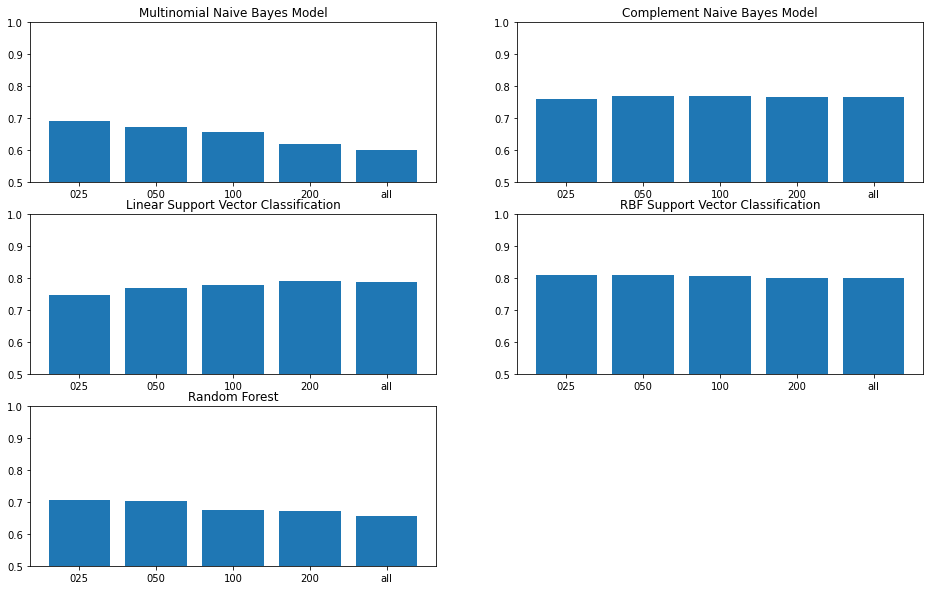

In [69]:
# 결과 비교

plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.ylim([0.5, 1.0])
plt.bar(list(accuracy_mnb.keys()), list(accuracy_mnb.values()), width=0.8)
plt.title('Multinomial Naive Bayes Model')

plt.subplot(3, 2, 2)
plt.ylim([0.5, 1.0])
plt.bar(list(accuracy_cnb.keys()), list(accuracy_cnb.values()), width=0.8)
plt.title('Complement Naive Bayes Model')

plt.subplot(3, 2, 3)
plt.ylim([0.5, 1.0])
plt.bar(list(accuracy_lsvc.keys()), list(accuracy_lsvc.values()), width=0.8)
plt.title('Linear Support Vector Classification')

plt.subplot(3, 2, 4)
plt.ylim([0.5, 1.0])
plt.bar(list(accuracy_rbfsvc.keys()), list(accuracy_rbfsvm.values()), width=0.8)
plt.title('RBF Support Vector Classification')

plt.subplot(3, 2, 5)
plt.ylim([0.5, 1.0])
plt.bar(list(accuracy_rforest.keys()), list(accuracy_rforest.values()), width=0.8)
plt.title('Random Forest')

plt.show()

#### 분석
- 상대적으로 서포트벡터머신 기반의 분류기가 좋은 성능을 보임
- 서포트벡터머신 기반의 분류기를 제외한 다른 분류기에서는 단어의 수가 증가할 수록 분류기의 성능이 낮아짐.
- 생각해볼 수 있는 원인으로 단어의 수가 증가할 수록 DTM 벡터의 크기가 커지며, 정확한 분류를 위한 데이터가 충분하지 않기 때문
- 서포트벡터머신 기반의 분류기에서는 반복 횟수가 충분하지 않다는 경고를 출력함. -> **반복회수에 따른 성능 비교 필요함**
- 서포트벡터머신 기반의 분류기는 학습 과정에 긴 시간이 필요함 -> **알고리즘 별로 학습 시간을 측정해서 비교 필요함**

### 4. 딥러닝 기법

In [73]:
# 모델 구성 - LSTM - 임베딩층 없이 LSTM - Dense - Dropout - Dense 구성
LSTM_DIM = 128
DENSE_DIM = 64
DROPOUT = 0.1

inputs = tf.keras.Input(shape=(2430, 1))
hidden_1 = tf.keras.layers.LSTM(LSTM_DIM)(inputs)
hidden_2 = tf.keras.layers.Dense(DENSE_DIM, activation='relu')(hidden_1)
hidden_3 = tf.keras.layers.Dropout(DROPOUT)(hidden_2)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(hidden_3)

lstm_model = tf.keras.Model(inputs, outputs)

lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2430, 1)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [74]:
# 모델 학습 구성
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
best_model_check = tf.keras.callbacks.ModelCheckpoint(filepath='news_classification_lstm.keras', monitor='loss', save_best_only=True)

EPOCHS = 10
BATCH_SIZE = 512

In [91]:
# 학습
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(tfidf_x_train_set['025'].shape)
x_train = np.array(tfidf_x_train_set['025'])
print(x_train.shape)

#x_train = np.reshape(tfidf_x_train_set['025'], (8982, 2430, -1))

#lstm_history = lstm_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=best_model_check)

(8982, 2430)
()


### 회고
- 전통적인 머신러닝 기법의 분류기의 성능 비교를 해볼 수 있는 시간이었습니다.
- 서포트벡터머신 기반의 분류기가 상대적으로 좋은 성능을 보여줬지만, 학습에 상당한 시간이 걸리는 점이 단점임을 확인했습니다.
- 선형 회귀나 부스팅 기법 등 확인되지 않은 다른 기법에 대한 성능 비교도 필요할 것 같습니다.